In [134]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

import pandas as pd

import imodels
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn.dataset import Dataset

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data
The first thing we will do is load in the data. The Dataset().get_data() function isn't fully set up yet, so I will manually load the csv file.

In [122]:
# Load the data. Will need to edit this hardcoded path in order to use on different machine. 

df_train_raw = pd.read_csv(f"/Users/austinzane/Work/STAT_215A/Lab/stat-215-a-final-lab/rule-vetting/data/tbi_pecarn/raw/data_knn_imputation.csv")
df_train_raw.head()

# We evantually hope to use the following command instead:
#df_train, df_tune, _ = Dataset().load_data(load_csvs=True)

#Dataset().get_data(load_csvs=True)



,GCSTotal,AgeinYears,AgeInMonth,ClavNeck_0,ClavNeck_1,ClavNeck_92,ClavTem_0,ClavTem_1,ClavTem_92,Hema_0,...,Race_90,SFxPalp_0,SFxPalp_1,SFxPalp_2,SFxBasHem_0,SFxBasHem_1,SFxBasHem_92,AgeTwoPlus_1,AgeTwoPlus_2,outcome
0,15,16,197,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0.0
1,15,5,64,0,0,1,0,0,1,1,...,0,1,0,0,0,0,1,0,1,0.0
2,15,1,13,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,1,0,NaN
3,15,3,46,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,0,1,0.0
4,15,4,51,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,NaN


### NA values

This dataset (data_knn_imputation.csv) still has NA values in the 'outcome' column. It's possible that a member function of Dataset() is supposed to take care of them, but I will just drop those rows for now.

In [128]:
# This is the proportion of NA outcome values
how_many_na = df_train_raw.loc[:, "outcome"].isna().sum()
how_many_total = df_train_raw.shape[0]
print(how_many_na/how_many_total)

df_train = df_train_raw.dropna()

0.022752994435537112


### Predictors

This data set contains the names of variables that we deemed important for our predictions. I believe that there were supposed to be 25 of them, but this dataset contains many more.

In [129]:
# Load the important predictor names
predictors_df = pd.read_csv(f"/Users/austinzane/Work/STAT_215A/Lab/stat-215-a-final-lab/rule-vetting/data/predictors.csv")
predictors_df.head()

# We need to add 'outcome' to this list because we will use it to select columns from the raw data
predictors_list = predictors['Predictor'].tolist()
predictors_list.append('outcome')

# Setting up data

The next step is selecting the important columns and splitting the data into X and y data structures for modelling purposes. In addition, we will be training two models: one for children under 2yo and one for children over 2yo. This was suggested by the authors of the accompanying paper. 

In [135]:
# Set the data up for training
selected_pred_data = df_train[predictors_list]
selected_pred_data.head()

X = selected_pred_data.drop(columns = 'outcome')
y = selected_pred_data['outcome'].values


# Divide to get data for children under 2yo and for children over 2yo
X_young = X[X['AgeInMonth'] <= 24]
y_young = y[X['AgeInMonth'] <= 24]

X_old = X[X['AgeInMonth'] > 24]
y_old = y[X['AgeInMonth'] > 24]

### Training and testing data

We will randomly split the data into training and testing datasets to evaluate performance. The folling code is incorrect because it doesn't ensure that the class proportions will be the same across datasets.

In [137]:
X_train_young, X_test_young, y_train_young, y_test_young = train_test_split(X_young, y_young, test_size=0.3, random_state=1) # 70% training and 30% test
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(X_old, y_old, test_size=0.3, random_state=1) # 70% training and 30% test

# Modelling patients under 2 years of age.

We will add 500 weight to cases with **outcome = 1**, as done in the paper.

In [179]:
dt_young = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1: 5e2})
dt_young.fit(X_young, y_young)

DecisionTreeClassifier(class_weight={0: 1, 1: 500.0}, max_depth=4)

In the following visualization of the classification tree, the top row of each node describes the predictor being used to make a decision. The third row describes the number of patients that are considered in the node. Lastly, the fourth row has a sort of score which we can use to classify patients who have arrived at this node. The first element of **value** indicated preference for **outcome = 0** while the second indicates **outcome = 1**. There is extra weight for patients with outcome of 1. 

Left branch is TRUE and right branch is FALSE.

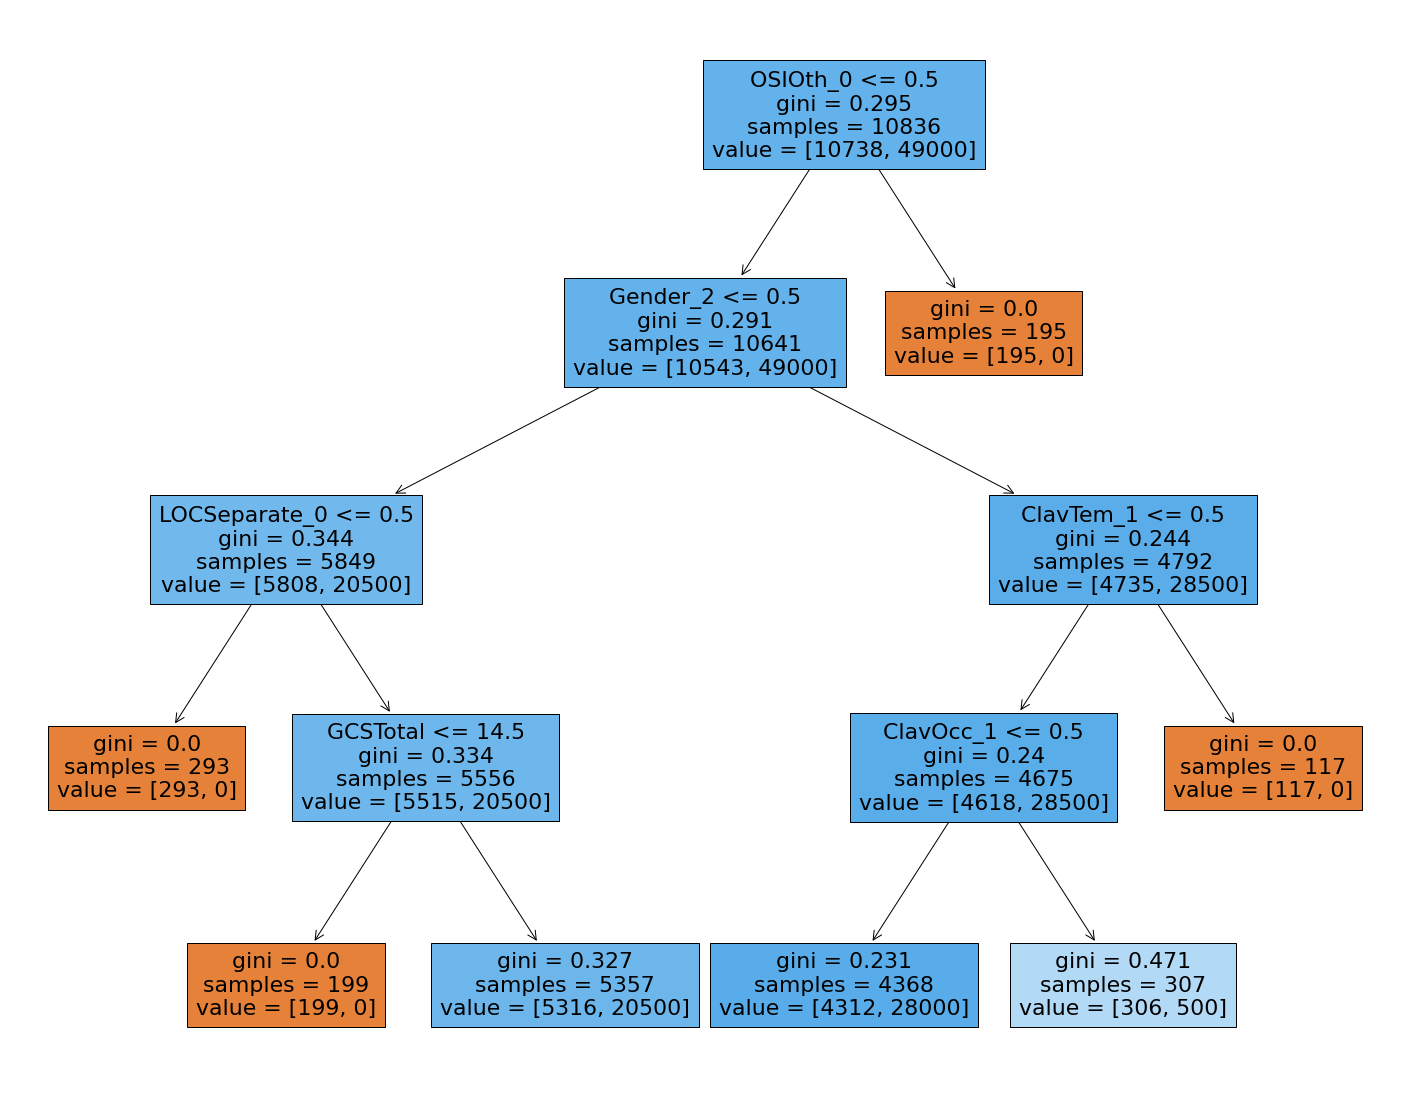

In [180]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt_young,
              feature_names=X_young.columns.values,
              filled = True)

This performance clearly leaves something to be desired. However, this model is merely intended to get us started. 

The features selected by a similar tree in the paper are AMS, Scalp haematoma, Loss of consciousness, Mechanism of injury, Palpable or unclear skull fracture, and Acting normally per parent.

The following cells have not been fully implemented. As we discussed in our recent meeting, prediction accuracy is the next priority.

In [181]:
y_pred_young = dt_young.predict(X_test_young)

print("Accuracy:",metrics.accuracy_score(y_test_young, y_pred_young))

Accuracy: 0.08428175945862812


# Modelling patients over 2 years of age.

This process will be nearly identical to the one above.

In [182]:
dt_old = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1: 5e2})
dt_old.fit(X_old, y_old)

DecisionTreeClassifier(class_weight={0: 1, 1: 500.0}, max_depth=4)

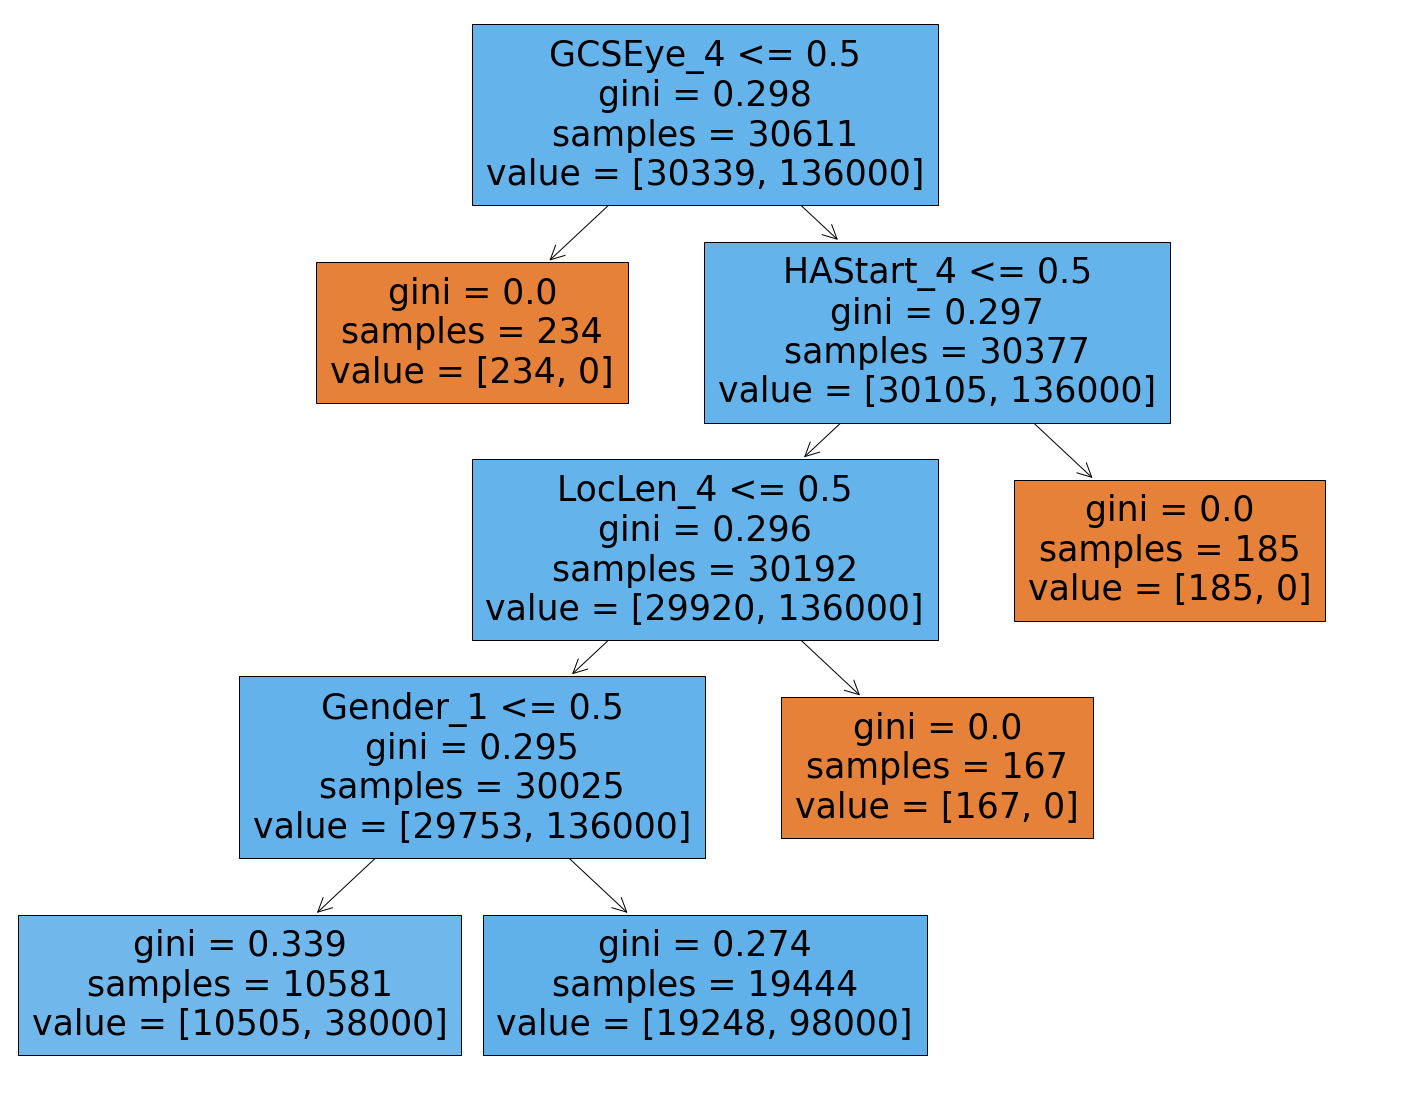

In [183]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt_old,
              feature_names=X_train_old.columns.values,
              filled = True)

In [159]:
y_pred_old = dt_old.predict(X_test_old)

print("Accuracy:",metrics.accuracy_score(y_test_old, y_pred_old))

Accuracy: 0.04888937282229965
